<a href="https://colab.research.google.com/github/pascalghanimi/Injury-Prediction-in-Runners/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data extraction for XGBoost
import pickle

with open("features.pkl", "rb") as f:
  features = pickle.load(f)

with open("features_days.pkl", "rb") as f:
  features_days = pickle.load(f)

with open("features_weeks.pkl", "rb") as f:
  features_weeks = pickle.load(f)

with open("features_objective.pkl", "rb") as f:
  features_objective = pickle.load(f)

with open("features_subjective.pkl", "rb") as f:
  features_subjective = pickle.load(f)

with open("labels.pkl", "rb") as f:
  labels = pickle.load(f)

print(features[0][0]) # first athlete first row
print(features_days[0][0])
print(features_weeks[0])
print(labels[0])

print(len(features[0][0])) # amount of features

[ 0.77523982  0.48379555 -0.34174298  1.12482238  4.65573275 -0.30257114
 -0.36195376  1.13221076  0.88408664  0.98946749 -1.07576228 -0.58780279
 -0.34515758 -0.21498604 -0.25818757 -0.30257114 -0.36653747 -1.10832632
 -1.12373205 -1.11938273  0.76147321 -0.58880824 -0.33963599 -0.22015974
 -0.26519341  3.1128211  -0.36131219  0.94306135  0.88408664  0.88198911
 -1.08073515 -0.58890474 -0.33382237 -0.21223522 -0.26471133 -0.29617444
 -0.36131219 -1.10795815 -1.12373205 -1.11942205  0.7667035  -0.5913292
 -0.33382237 -0.22367068 -0.26509659 -0.29617444  2.42402301  0.57403001
  0.88989186  0.9965464   0.78053094  2.39956507  5.70866175 -0.21223522
 -0.26519341  3.3763886  -0.35067995  1.13636789  0.88989186  0.88771258
  0.78584128 -0.58219763 -0.3393889  -0.21762941 -0.25818757 -0.28968273
  2.19131074  0.96442407  0.89572629  0.67074481  0.37283858 -0.47040001
 -0.01179093  0.73505066  1.36358038  0.5749299   0.54093582  1.26319022
  2.68987335 -0.05530893  0.11981333  1.16084473  1.

In [ ]:
import numpy as np

X = np.vstack([features[athlete_id] for athlete_id in features])
X_days = np.vstack([features_days[athlete_id] for athlete_id in features_days])
X_weeks = np.vstack([features_weeks[athlete_id] for athlete_id in features_weeks])
X_objective = np.vstack([features_objective[athlete_id] for athlete_id in features_objective])
X_subjective = np.vstack([features_subjective[athlete_id] for athlete_id in features_subjective])

Y = np.hstack([labels[athlete_id] for athlete_id in labels])


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train_days, X_temp_days, Y_train_days, Y_temp_days = train_test_split(X_days, Y, test_size=0.3, random_state=42)
X_val_days, X_test_days, Y_val_days, Y_test_days = train_test_split(X_temp_days, Y_temp_days, test_size=0.5, random_state=42)

X_train_weeks, X_temp_weeks, Y_train_weeks, Y_temp_weeks = train_test_split(X_weeks, Y, test_size=0.3, random_state=42)
X_val_weeks, X_test_weeks, Y_val_weeks, Y_test_weeks = train_test_split(X_temp_weeks, Y_temp_weeks, test_size=0.5, random_state=42)

X_train_subjective, X_temp_subjective, Y_train_subjective, Y_temp_subjective = train_test_split(X_subjective, Y, test_size=0.3, random_state=42)
X_val_subjective, X_test_subjective, Y_val_subjective, Y_test_subjective = train_test_split(X_temp_subjective, Y_temp_subjective, test_size=0.5, random_state=42)

X_train_objective, X_temp_objective, Y_train_objective, Y_temp_objective = train_test_split(X_objective, Y, test_size=0.3, random_state=42)
X_val_objective, X_test_objective, Y_val_objective, Y_test_objective = train_test_split(X_temp_objective, Y_temp_objective, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_days.shape, X_val_days.shape, X_test_days.shape)
print(X_train_weeks.shape, X_val_weeks.shape, X_test_weeks.shape)
print(X_train_subjective.shape, X_val_subjective.shape, X_test_subjective.shape)
print(X_train_objective.shape, X_val_objective.shape, X_test_objective.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)


(29876, 139) (6402, 139) (6402, 139)
(29876, 70) (6402, 70) (6402, 70)
(29876, 69) (6402, 69) (6402, 69)
(29876, 48) (6402, 48) (6402, 48)
(29876, 91) (6402, 91) (6402, 91)
(29876,) (6402,) (6402,)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 23.7 MB/s eta 0:00:00


In [ ]:
def get_training_batch(X_train, Y_train, batch_size):
    injured_indices = np.where(Y_train == 1)[0]
    uninjured_indices = np.where(Y_train == 0)[0]

    injured_sample = np.random.choice(injured_indices, size=batch_size // 2, replace=True)
    uninjured_sample = np.random.choice(uninjured_indices, size=batch_size // 2, replace=True)

    selected_indices = np.concatenate([injured_sample, uninjured_sample])
    np.random.shuffle(selected_indices)

    X_batch = X_train[selected_indices]
    Y_batch = Y_train[selected_indices]

    return X_batch, Y_batch

In [ ]:
print(f"Percentage of injuries in the test set: {np.mean(Y_test):.4f}")

n_injuries = np.sum(Y_test == 1)
n_healthy = np.sum(Y_test == 0)
n_total = len(Y_test)

print(f"Total Test Samples: {n_total}")
print(f"Verletzungen (positiv): {n_injuries}")
print(f"Keine Verletzung (negativ): {n_healthy}")


Anteil Verletzungen im Testset: 0.0162
Total Test Samples: 6402
Verletzungen (positiv): 104
Keine Verletzung (negativ): 6298


In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore")

def tune_params(X_train, Y_train, X_val, Y_val):
    def xgboost_objective(trial):
        params = {
            # Fixed Parameters
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "verbosity": 0,
            "tree_method": "gpu_hist",
            "device": "cuda",

            # Hyperparameter Search Space
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"])
        }

        # Batch Sampling
        X_batch, Y_batch = get_training_batch(X_train, Y_train, 2048)

        # Convert to DMatrix
        dtrain = xgb.DMatrix(X_batch, label=Y_batch)
        dvalid = xgb.DMatrix(X_val, label=Y_val)

        # Training with Early Stopping
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=10000,
            evals=[(dvalid, "eval")],
            early_stopping_rounds=30,
            verbose_eval=False,
        )

        # Validation AUC
        val_proba = model.predict(dvalid)
        return roc_auc_score(Y_val, val_proba)

    # Optuna-Study
    xgb_study = optuna.create_study(direction="maximize")
    xgb_study.optimize(xgboost_objective, n_trials=50)

    print("Best XGBoost parameters:", xgb_study.best_params)
    return xgb_study.best_params

In [ ]:
tuned_params = tune_params(X_train, Y_train, X_val, Y_val)
tuned_params_days = tune_params(X_train_days, Y_train_days, X_val_days, Y_val_days)
tuned_params_weeks = tune_params(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks)
tuned_params_objective = tune_params(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective)
tuned_params_subjective = tune_params(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective)

[I 2025-03-25 06:37:53,603] A new study created in memory with name: no-name-ac84385f-1acf-408d-b6b3-b0a8f6de5442
[I 2025-03-25 06:38:33,894] Trial 0 finished with value: 0.7034956962974681 and parameters: {'learning_rate': 0.03485600183122133, 'max_depth': 3, 'subsample': 0.8801574181607905, 'colsample_bytree': 0.9193968338467927, 'min_child_weight': 36, 'reg_alpha': 3.1113299703612545, 'reg_lambda': 0.18844240882437135, 'gamma': 1.7016431263359622, 'grow_policy': 'lossguide', 'booster': 'dart'}. Best is trial 0 with value: 0.7034956962974681.
[I 2025-03-25 06:38:34,718] Trial 1 finished with value: 0.7023335891922085 and parameters: {'learning_rate': 0.0515298402820944, 'max_depth': 12, 'subsample': 0.9322923622042796, 'colsample_bytree': 0.6323748535656261, 'min_child_weight': 37, 'reg_alpha': 0.9697572371029745, 'reg_lambda': 1.5986278030589207, 'gamma': 1.420056470529374, 'grow_policy': 'depthwise', 'booster': 'gbtree'}. Best is trial 0 with value: 0.7034956962974681.
[I 2025-03-2

Best XGBoost parameters: {'learning_rate': 0.023054365447051712, 'max_depth': 10, 'subsample': 0.7429482413696459, 'colsample_bytree': 0.9624636127778242, 'min_child_weight': 6, 'reg_alpha': 2.4997469591115338, 'reg_lambda': 3.3298948432267093, 'gamma': 1.0464986086983894, 'grow_policy': 'depthwise', 'booster': 'dart'}


[I 2025-03-25 06:41:37,831] Trial 0 finished with value: 0.6911265798308988 and parameters: {'learning_rate': 0.03920008303369386, 'max_depth': 11, 'subsample': 0.9843104848995066, 'colsample_bytree': 0.7073408766023042, 'min_child_weight': 90, 'reg_alpha': 4.044054849684663, 'reg_lambda': 1.0892865854826894, 'gamma': 1.9765836999851456, 'grow_policy': 'lossguide', 'booster': 'dart'}. Best is trial 0 with value: 0.6911265798308988.
[I 2025-03-25 06:41:44,940] Trial 1 finished with value: 0.675247704594327 and parameters: {'learning_rate': 0.04315096270802845, 'max_depth': 12, 'subsample': 0.8821183512688238, 'colsample_bytree': 0.9943684155487919, 'min_child_weight': 63, 'reg_alpha': 2.0590401210936315, 'reg_lambda': 4.595219581843917, 'gamma': 3.3363563663125637, 'grow_policy': 'depthwise', 'booster': 'dart'}. Best is trial 0 with value: 0.6911265798308988.
[I 2025-03-25 06:41:45,116] Trial 2 finished with value: 0.6983121126716549 and parameters: {'learning_rate': 0.11351639471163105

Best XGBoost parameters: {'learning_rate': 0.02676166627692479, 'max_depth': 4, 'subsample': 0.8936105161996422, 'colsample_bytree': 0.7420252830865415, 'min_child_weight': 42, 'reg_alpha': 3.823092668382464, 'reg_lambda': 1.5254622772103918, 'gamma': 4.465200924113334, 'grow_policy': 'lossguide', 'booster': 'gbtree'}


[I 2025-03-25 06:42:43,113] Trial 1 finished with value: 0.666741861832301 and parameters: {'learning_rate': 0.07563483533203473, 'max_depth': 11, 'subsample': 0.6924664581869466, 'colsample_bytree': 0.7584648029860159, 'min_child_weight': 14, 'reg_alpha': 1.7844422785281004, 'reg_lambda': 2.473323970771968, 'gamma': 4.392666700053749, 'grow_policy': 'lossguide', 'booster': 'gbtree'}. Best is trial 1 with value: 0.666741861832301.
[I 2025-03-25 06:42:44,035] Trial 2 finished with value: 0.6750484862334254 and parameters: {'learning_rate': 0.1261376696232148, 'max_depth': 9, 'subsample': 0.9767827103706845, 'colsample_bytree': 0.8412172069804468, 'min_child_weight': 59, 'reg_alpha': 0.8951203976401162, 'reg_lambda': 3.1565401765114824, 'gamma': 4.899270852767517, 'grow_policy': 'depthwise', 'booster': 'dart'}. Best is trial 2 with value: 0.6750484862334254.
[I 2025-03-25 06:42:46,126] Trial 3 finished with value: 0.6303122454838955 and parameters: {'learning_rate': 0.016933945313062037,

Best XGBoost parameters: {'learning_rate': 0.03950269445633835, 'max_depth': 8, 'subsample': 0.5962648648943886, 'colsample_bytree': 0.9004907378822207, 'min_child_weight': 2, 'reg_alpha': 1.4684027359308645, 'reg_lambda': 1.0904343453630814, 'gamma': 4.200673037603789, 'grow_policy': 'lossguide', 'booster': 'dart'}


[I 2025-03-25 06:43:55,746] Trial 0 finished with value: 0.6867105728309124 and parameters: {'learning_rate': 0.005510960493485893, 'max_depth': 10, 'subsample': 0.5049362121648795, 'colsample_bytree': 0.6142866081123469, 'min_child_weight': 1, 'reg_alpha': 0.6722609270938784, 'reg_lambda': 0.17312634716408537, 'gamma': 2.3485075833702878, 'grow_policy': 'lossguide', 'booster': 'gbtree'}. Best is trial 0 with value: 0.6867105728309124.
[I 2025-03-25 06:44:10,984] Trial 1 finished with value: 0.710351151657907 and parameters: {'learning_rate': 0.06680407862524615, 'max_depth': 5, 'subsample': 0.8755449071703596, 'colsample_bytree': 0.6917955503136375, 'min_child_weight': 66, 'reg_alpha': 2.8130232829333512, 'reg_lambda': 0.5759064122456425, 'gamma': 1.1441498979552196, 'grow_policy': 'depthwise', 'booster': 'dart'}. Best is trial 1 with value: 0.710351151657907.
[I 2025-03-25 06:44:11,646] Trial 2 finished with value: 0.6837994457042076 and parameters: {'learning_rate': 0.03412507873900

Best XGBoost parameters: {'learning_rate': 0.06829445267704352, 'max_depth': 5, 'subsample': 0.5677747518753463, 'colsample_bytree': 0.5974665179700467, 'min_child_weight': 17, 'reg_alpha': 1.481536196708097, 'reg_lambda': 0.6501246546763638, 'gamma': 1.6828191253989508, 'grow_policy': 'lossguide', 'booster': 'gbtree'}


[I 2025-03-25 06:51:34,609] Trial 0 finished with value: 0.6000154296573639 and parameters: {'learning_rate': 0.029837083826890952, 'max_depth': 11, 'subsample': 0.8465097351091275, 'colsample_bytree': 0.9495578592620364, 'min_child_weight': 56, 'reg_alpha': 0.6364637148678409, 'reg_lambda': 4.232019773945289, 'gamma': 3.9012998433103308, 'grow_policy': 'lossguide', 'booster': 'dart'}. Best is trial 0 with value: 0.6000154296573639.
[I 2025-03-25 06:51:34,717] Trial 1 finished with value: 0.594947080181484 and parameters: {'learning_rate': 0.05277926979718404, 'max_depth': 10, 'subsample': 0.871042969872206, 'colsample_bytree': 0.5938998692624257, 'min_child_weight': 89, 'reg_alpha': 2.0931209181174286, 'reg_lambda': 2.548827641557655, 'gamma': 1.7046026404415038, 'grow_policy': 'lossguide', 'booster': 'gbtree'}. Best is trial 0 with value: 0.6000154296573639.
[I 2025-03-25 06:51:35,056] Trial 2 finished with value: 0.613107200962498 and parameters: {'learning_rate': 0.1598976397566036

Best XGBoost parameters: {'learning_rate': 0.07626514651835356, 'max_depth': 8, 'subsample': 0.7347971099223761, 'colsample_bytree': 0.9833143819418402, 'min_child_weight': 51, 'reg_alpha': 4.23474327485131, 'reg_lambda': 3.4698172392340236, 'gamma': 2.9085276693413196, 'grow_policy': 'lossguide', 'booster': 'dart'}


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV

def train(X_train, Y_train, X_val, Y_val, X_test, Y_test, best_params):
    # Parameteradaptations for XGBoost
    params = {
        **best_params,
        "tree_method": "gpu_hist",
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "verbosity": 0,
        "n_estimators": 10000,
        "early_stopping_rounds": 30
    }

    models = []
    for model_idx in range(9):
        X_batch, Y_batch = get_training_batch(X_train, Y_train, 4096)

        # Training with Early Stopping
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_batch,
            Y_batch,
            eval_set=[(X_val, Y_val)],
            verbose=False
        )

        val_proba = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(Y_val, val_proba)
        print(f"Modell {model_idx+1} | Val-AUC: {val_auc:.4f}")
        models.append(model)

    # Calibration
    calibrated_models = [
        CalibratedClassifierCV(m, method='sigmoid', cv="prefit").fit(X_val, Y_val)
        for m in models
    ]

    # Ensemble Prediction
    def ensemble_predict(models, X):
        probas = np.stack([m.predict_proba(X)[:, 1] for m in models])
        return np.mean(probas, axis=0)

    # Metrics
    Y_proba_test = ensemble_predict(calibrated_models, X_test)
    test_auc = roc_auc_score(Y_test, Y_proba_test)

    # Optimal Threshold
    fpr, tpr, thresholds = roc_curve(Y_test, Y_proba_test)
    weight = 1.3
    j_scores = weight * tpr - fpr
    best_threshold = thresholds[np.argmax(j_scores)]

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(Y_test, Y_proba_test > best_threshold).ravel()

    # Metric Calculations
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    print(f"\n🔥 Final Test-AUC: {test_auc:.4f}")
    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Recall: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return calibrated_models, test_auc, sensitivity, specificity, precision, f1, Y_test, Y_proba_test

In [ ]:
# Training with all features (weeks and days combined)
xgb_models = train(X_train, Y_train, X_val, Y_val, X_test, Y_test, tuned_params)

Modell 1 | Val-AUC: 0.7291
Modell 2 | Val-AUC: 0.7158
Modell 3 | Val-AUC: 0.7454
Modell 4 | Val-AUC: 0.7449
Modell 5 | Val-AUC: 0.6829
Modell 6 | Val-AUC: 0.7326
Modell 7 | Val-AUC: 0.7318
Modell 8 | Val-AUC: 0.7170
Modell 9 | Val-AUC: 0.7261

🔥 Finale Test-AUC: 0.7262
Optimaler Schwellenwert: 0.0076
Sensitivity: 0.9038
Specificity: 0.3889
Precision: 0.0238
F1-Score: 0.0465


In [ ]:
# Training with days data
xgb_models_days = train(X_train_days, Y_train_days, X_val_days, Y_val_days, X_test_days, Y_test_days, tuned_params_days)

Modell 1 | Val-AUC: 0.7085
Modell 2 | Val-AUC: 0.6863
Modell 3 | Val-AUC: 0.6882
Modell 4 | Val-AUC: 0.6859
Modell 5 | Val-AUC: 0.7063
Modell 6 | Val-AUC: 0.7023
Modell 7 | Val-AUC: 0.7044
Modell 8 | Val-AUC: 0.7145
Modell 9 | Val-AUC: 0.7129

🔥 Finale Test-AUC: 0.7088
Optimaler Schwellenwert: 0.0084
Sensitivity: 0.8846
Specificity: 0.4082
Precision: 0.0241
F1-Score: 0.0469


In [ ]:
# Training with weeks data
xgb_models_weeks = train(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks, X_test_weeks, Y_test_weeks, tuned_params_weeks)

Modell 1 | Val-AUC: 0.7033
Modell 2 | Val-AUC: 0.6774
Modell 3 | Val-AUC: 0.6868
Modell 4 | Val-AUC: 0.7069
Modell 5 | Val-AUC: 0.6701
Modell 6 | Val-AUC: 0.6832
Modell 7 | Val-AUC: 0.6907
Modell 8 | Val-AUC: 0.6829
Modell 9 | Val-AUC: 0.6667

🔥 Finale Test-AUC: 0.6994
Optimaler Schwellenwert: 0.0120
Sensitivity: 0.7212
Specificity: 0.5959
Precision: 0.0286
F1-Score: 0.0551


In [ ]:
# Training with objective data
xgb_models_objective = train(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective, X_test_objective, Y_test_objective, tuned_params_objective)

Modell 1 | Val-AUC: 0.7245
Modell 2 | Val-AUC: 0.7090
Modell 3 | Val-AUC: 0.7330
Modell 4 | Val-AUC: 0.7306
Modell 5 | Val-AUC: 0.7052
Modell 6 | Val-AUC: 0.7003
Modell 7 | Val-AUC: 0.7106
Modell 8 | Val-AUC: 0.7112
Modell 9 | Val-AUC: 0.7261

🔥 Finale Test-AUC: 0.7162
Optimaler Schwellenwert: 0.0103
Sensitivity: 0.7788
Specificity: 0.5438
Precision: 0.0274
F1-Score: 0.0530


In [ ]:
# Training with subjective data
xgb_models_subjective = train(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective, X_test_subjective, Y_test_subjective, tuned_params_subjective)

Modell 1 | Val-AUC: 0.5872
Modell 2 | Val-AUC: 0.5975
Modell 3 | Val-AUC: 0.6188
Modell 4 | Val-AUC: 0.6094
Modell 5 | Val-AUC: 0.6101
Modell 6 | Val-AUC: 0.6383
Modell 7 | Val-AUC: 0.6250
Modell 8 | Val-AUC: 0.5993
Modell 9 | Val-AUC: 0.6167

🔥 Finale Test-AUC: 0.6483
Optimaler Schwellenwert: 0.0119
Sensitivity: 0.7308
Specificity: 0.5070
Precision: 0.0239
F1-Score: 0.0463


In [ ]:
# Calculate average metrics over 5 rounds

amount_of_trainings = 5
all_auc_scores = []
auc_scores_days = []
auc_scores_weeks = []
auc_scores_objective = []
auc_scores_subjective = []

all_sensitivity = []
sensitivity_days = []
sensitivity_weeks = []
sensitivity_objective = []
sensitivity_subjective = []

all_specificity = []
specificity_days = []
specificity_weeks = []
specificity_objective = []
specificity_subjective = []

all_precision = []
precision_days = []
precision_weeks = []
precision_objective = []
precision_subjective = []

all_f1 = []
f1_days = []
f1_weeks = []
f1_objective = []
f1_subjective = []

all_y_true = []
all_y_pred = []

y_true_days = []
y_pred_days = []

y_true_weeks = []
y_pred_weeks = []

y_true_objective = []
y_pred_objective = []

y_true_subjective = []
y_pred_subjective = []


def calculate_average_auc_over_10_rounds(train_fn, auc_scores_array, sensitivity_array, specificity_array, precision_array, f1_array, y_true_array, y_pred_array):
  for training in range(amount_of_trainings):
    _, auc, sensitivity, specificity, precision, f1, y_true, y_pred = train_fn()
    auc_scores_array.append(auc)
    sensitivity_array.append(sensitivity)
    specificity_array.append(specificity)
    precision_array.append(precision)
    f1_array.append(f1)
    y_true_array.append(y_true)
    y_pred_array.append(y_pred)

  mean_auc_score = np.mean(auc_scores_array)
  std_auc_score = np.std(auc_scores_array)
  mean_sensitivity = np.mean(sensitivity_array)
  std_sensitivity = np.std(sensitivity_array)
  mean_specificity = np.mean(specificity_array)
  std_specificity = np.std(specificity_array)
  mean_precision = np.mean(precision_array)
  std_precision = np.std(precision_array)
  mean_f1 = np.mean(f1_array)
  std_f1 = np.std(f1_array)
  print(f"\033[1mMean AUC Score: {mean_auc_score}\033[0m")
  print(f"Standard Deviation of AUC Scores: {std_auc_score}")
  print(f"\033[1mMean Sensitivity: {mean_sensitivity}\033[0m")
  print(f"Standard Deviation of Sensitivity: {std_sensitivity}")
  print(f"\033[1mMean Specificity: {mean_specificity}\033[0m")
  print(f"Standard Deviation of Specificity: {std_specificity}")
  print(f"\033[1mMean Precision: {mean_precision}\033[0m")
  print(f"Standard Deviation of Precision: {std_precision}")
  print(f"\033[1mMean F1-Score: {mean_f1}\033[0m")
  print(f"Standard Deviation of F1-Score: {std_f1}")

calculate_average_auc_over_10_rounds(lambda: train(X_train, Y_train, X_val, Y_val, X_test, Y_test, tuned_params), all_auc_scores, all_sensitivity, all_specificity, all_precision, all_f1, all_y_true, all_y_pred)
calculate_average_auc_over_10_rounds(lambda: train(X_train_days, Y_train_days, X_val_days, Y_val_days, X_test_days, Y_test_days, tuned_params_days), auc_scores_days, sensitivity_days, specificity_days, precision_days, f1_days, y_true_days, y_pred_days)
calculate_average_auc_over_10_rounds(lambda: train(X_train_weeks, Y_train_weeks, X_val_weeks, Y_val_weeks, X_test_weeks, Y_test_weeks, tuned_params_weeks), auc_scores_weeks, sensitivity_weeks, specificity_weeks, precision_weeks, f1_weeks, y_true_weeks, y_pred_weeks)
calculate_average_auc_over_10_rounds(lambda: train(X_train_objective, Y_train_objective, X_val_objective, Y_val_objective, X_test_objective, Y_test_objective, tuned_params_objective), auc_scores_objective, sensitivity_objective, specificity_objective, precision_objective, f1_objective, y_true_objective, y_pred_objective)
calculate_average_auc_over_10_rounds(lambda: train(X_train_subjective, Y_train_subjective, X_val_subjective, Y_val_subjective, X_test_subjective, Y_test_subjective, tuned_params_subjective), auc_scores_subjective, sensitivity_subjective, specificity_subjective, precision_subjective, f1_subjective, y_true_subjective, y_pred_subjective)

Modell 1 | Val-AUC: 0.7098
Modell 2 | Val-AUC: 0.7146
Modell 3 | Val-AUC: 0.6886
Modell 4 | Val-AUC: 0.7258
Modell 5 | Val-AUC: 0.7206
Modell 6 | Val-AUC: 0.7200
Modell 7 | Val-AUC: 0.7227
Modell 8 | Val-AUC: 0.7071
Modell 9 | Val-AUC: 0.7283

🔥 Finale Test-AUC: 0.7193
Optimaler Schwellenwert: 0.0096
Sensitivity: 0.7981
Specificity: 0.5264
Precision: 0.0271
F1-Score: 0.0524
Modell 1 | Val-AUC: 0.7139
Modell 2 | Val-AUC: 0.7375
Modell 3 | Val-AUC: 0.7169
Modell 4 | Val-AUC: 0.6904
Modell 5 | Val-AUC: 0.7419
Modell 6 | Val-AUC: 0.7215
Modell 7 | Val-AUC: 0.7203
Modell 8 | Val-AUC: 0.7094
Modell 9 | Val-AUC: 0.7391

🔥 Finale Test-AUC: 0.7230
Optimaler Schwellenwert: 0.0097
Sensitivity: 0.7885
Specificity: 0.5394
Precision: 0.0275
F1-Score: 0.0531
Modell 1 | Val-AUC: 0.7319
Modell 2 | Val-AUC: 0.6710
Modell 3 | Val-AUC: 0.7217
Modell 4 | Val-AUC: 0.6908
Modell 5 | Val-AUC: 0.7173
Modell 6 | Val-AUC: 0.7138
Modell 7 | Val-AUC: 0.7263
Modell 8 | Val-AUC: 0.7006
Modell 9 | Val-AUC: 0.7159

🔥 

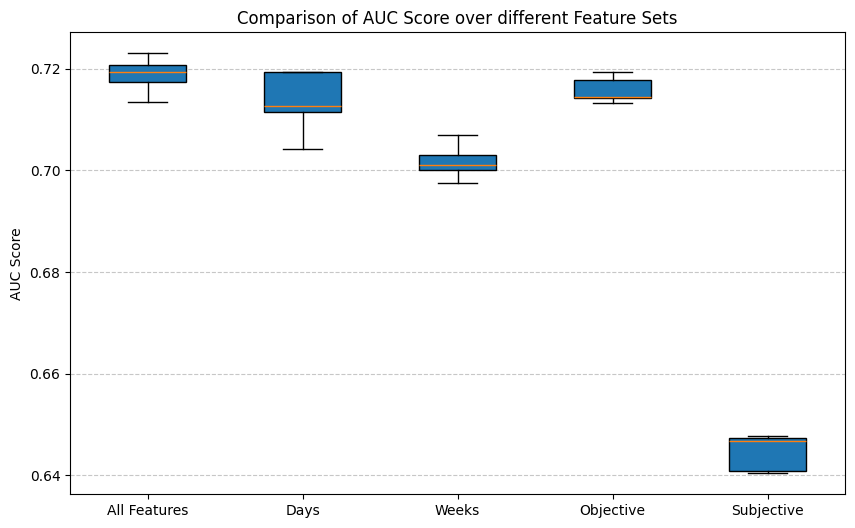

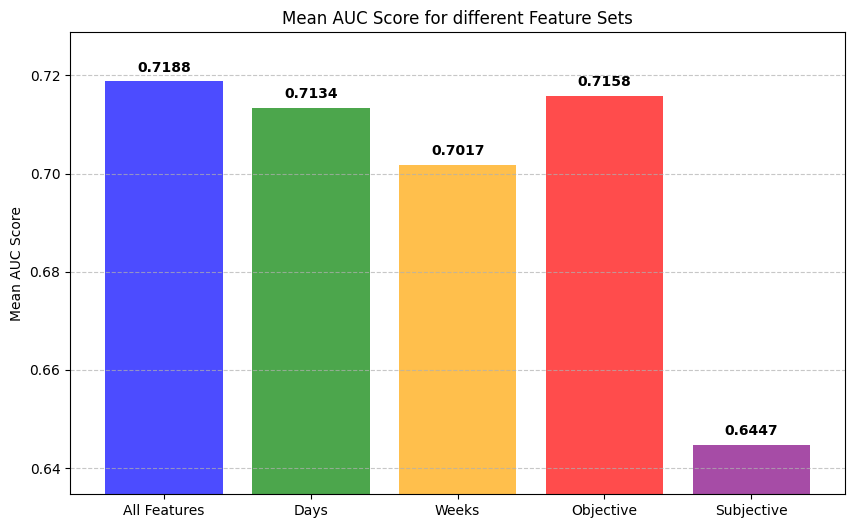

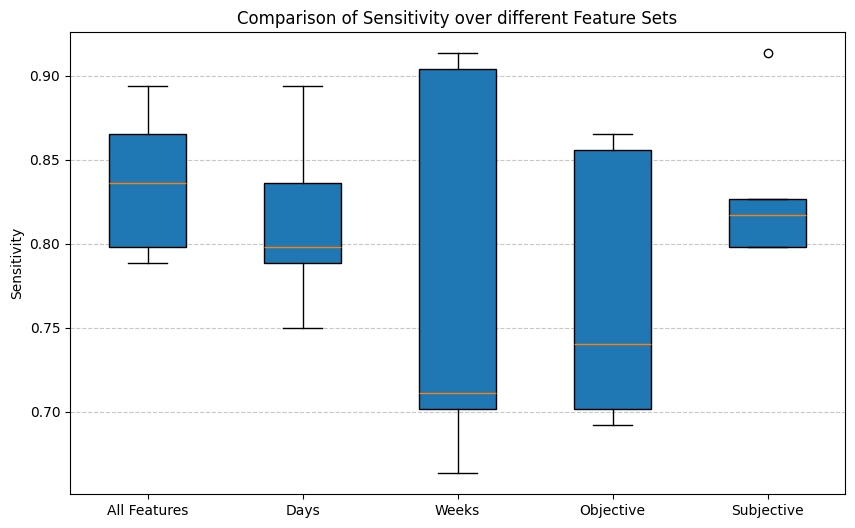

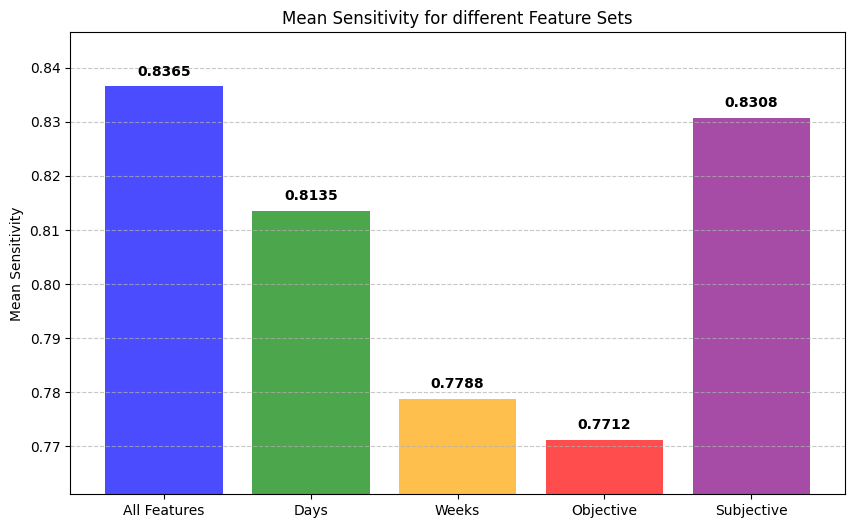

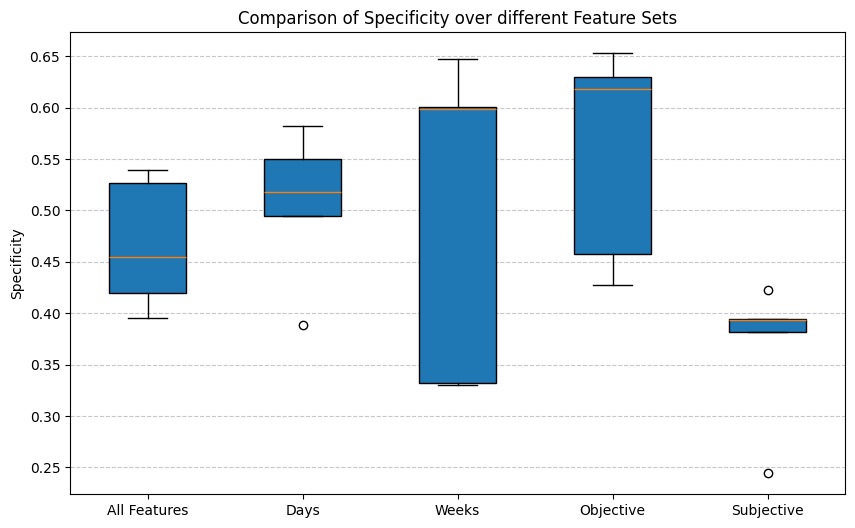

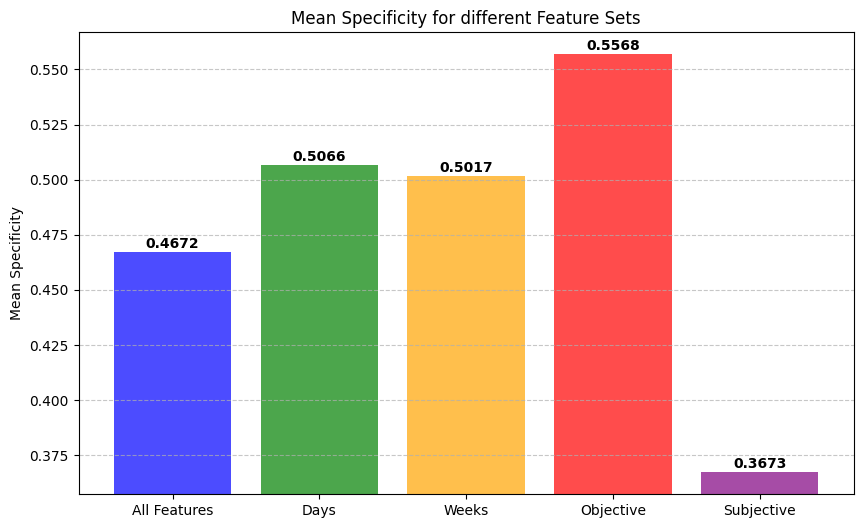

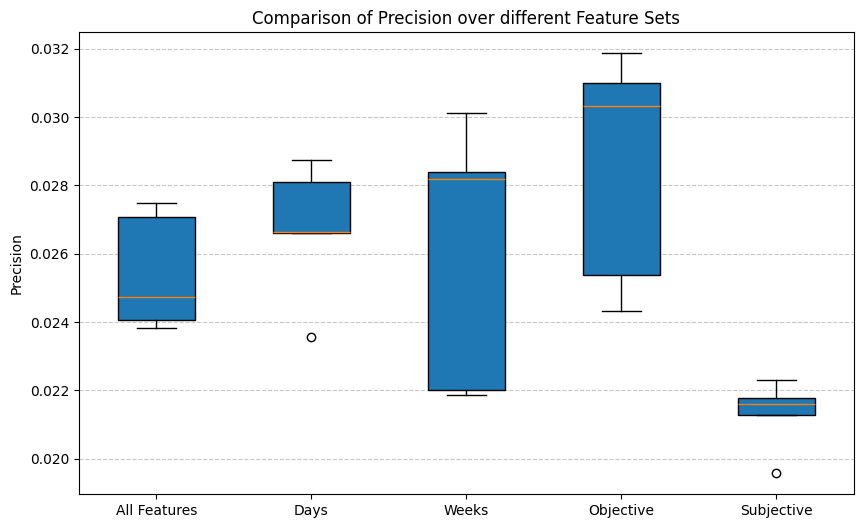

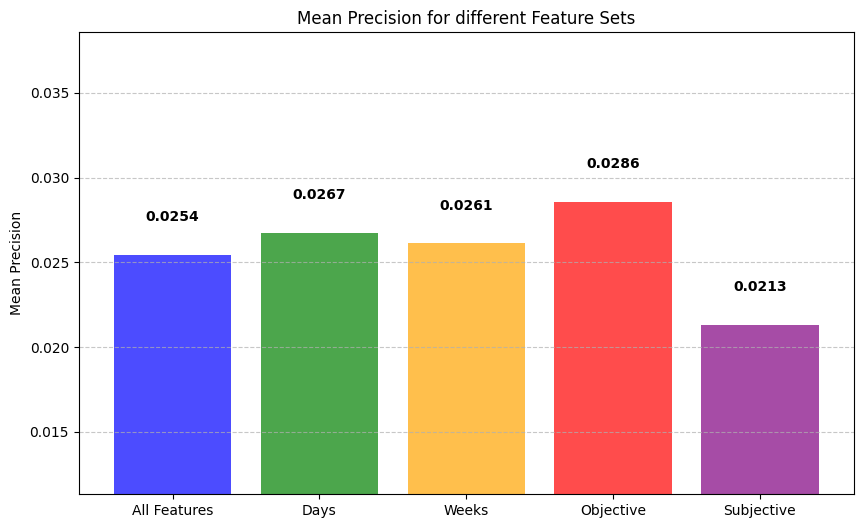

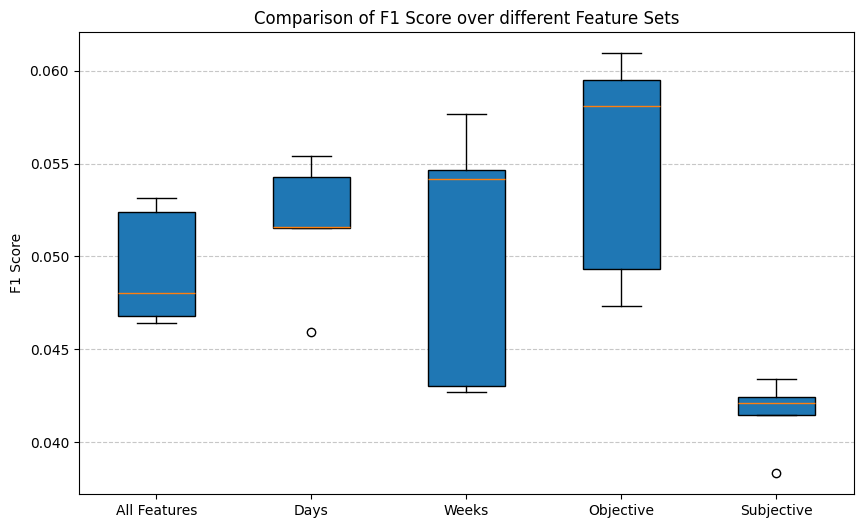

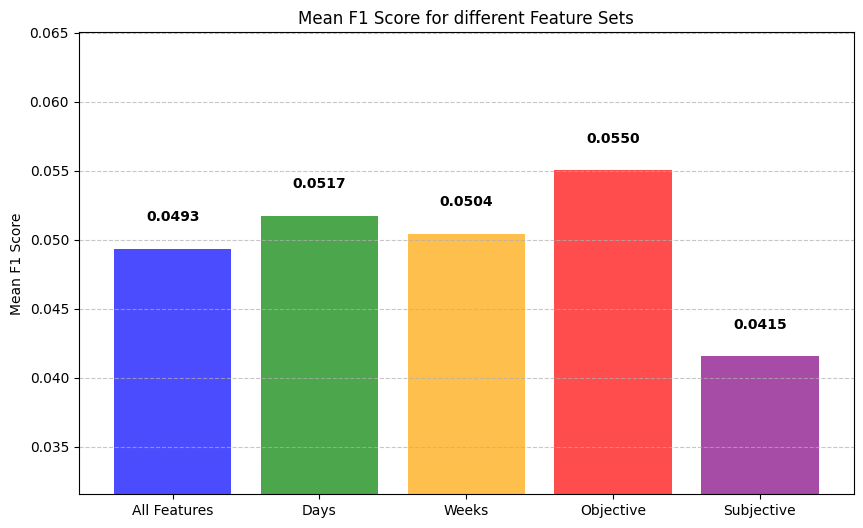

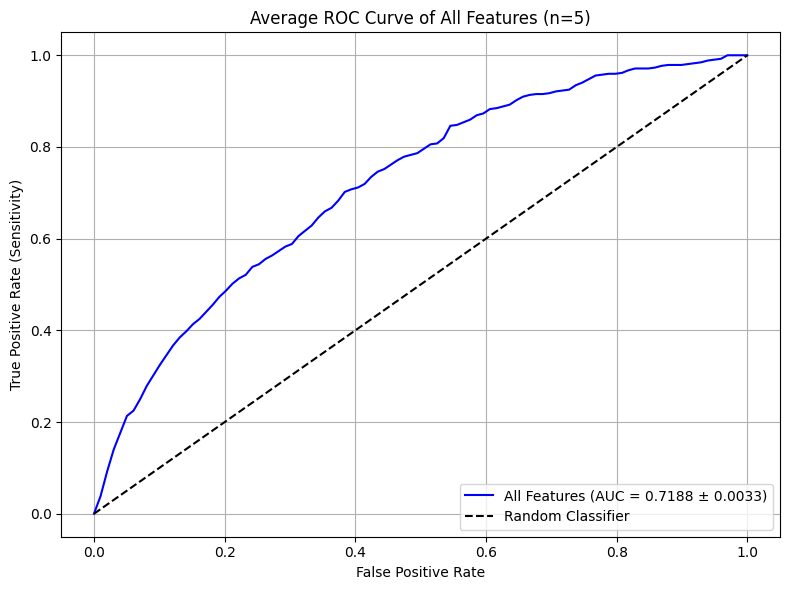

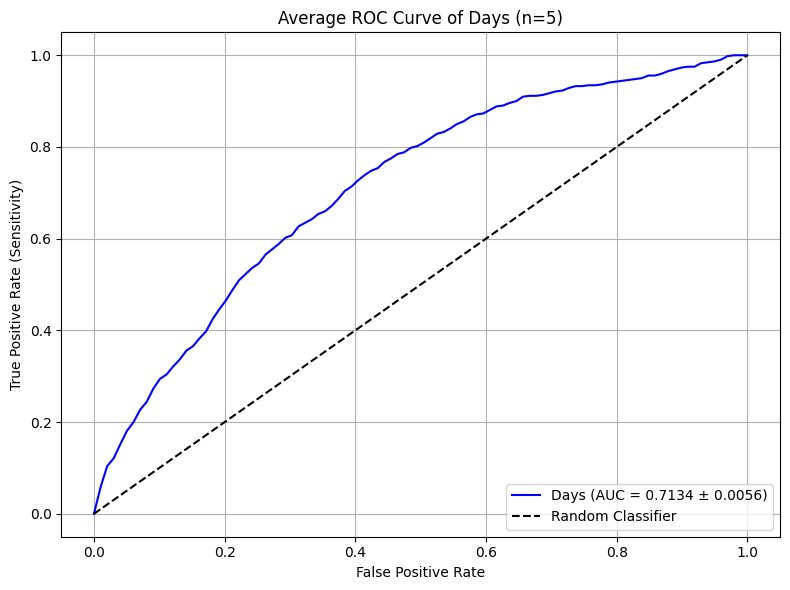

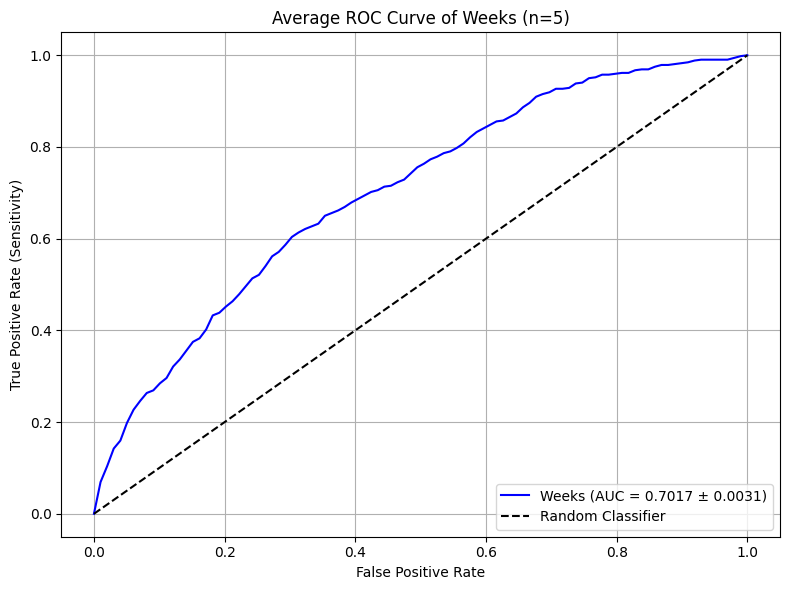

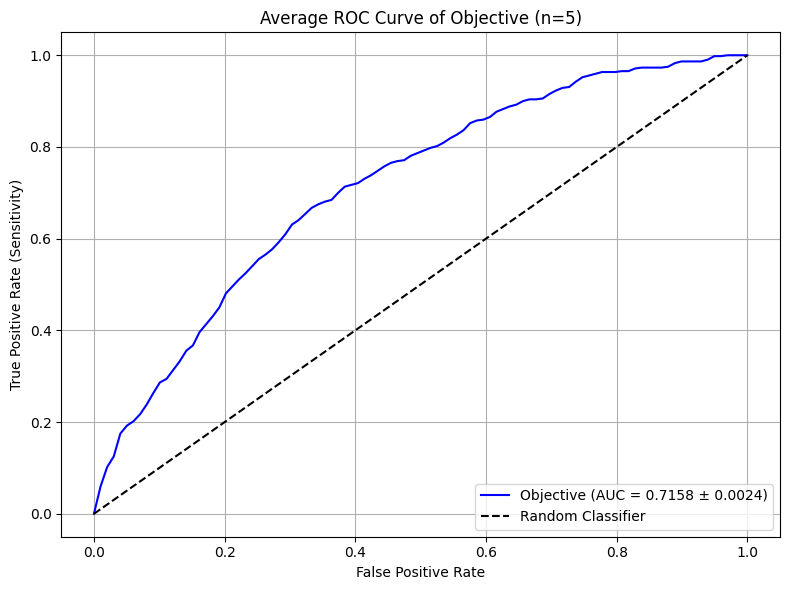

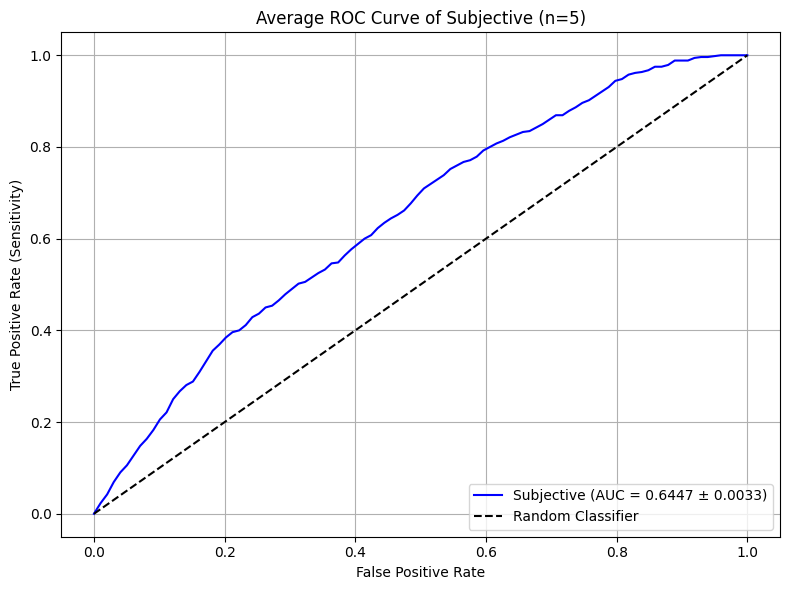

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

feature_set_names = ["All Features", "Days", "Weeks", "Objective", "Subjective"]

# Get all metrics
metrics = {
    "AUC Score": [all_auc_scores, auc_scores_days, auc_scores_weeks, auc_scores_objective, auc_scores_subjective],
    "Sensitivity": [all_sensitivity, sensitivity_days, sensitivity_weeks, sensitivity_objective, sensitivity_subjective],
    "Specificity": [all_specificity, specificity_days, specificity_weeks, specificity_objective, specificity_subjective],
    "Precision": [all_precision, precision_days, precision_weeks, precision_objective, precision_subjective],
    "F1 Score": [all_f1, f1_days, f1_weeks, f1_objective, f1_subjective],
}

# Plots
for metric_name, metric_data in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.boxplot(metric_data, labels=feature_set_names, patch_artist=True)
    plt.ylabel(metric_name)
    plt.title(f"Comparison of {metric_name} over different Feature Sets")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    mean_values = {name: np.mean(values) for name, values in zip(feature_set_names, metric_data)}

    plt.figure(figsize=(10, 6))
    plt.bar(mean_values.keys(), mean_values.values(),
            color=["blue", "green", "orange", "red", "purple"], alpha=0.7)
    plt.ylabel(f"Mean {metric_name}")
    plt.title(f"Mean {metric_name} for different Feature Sets")
    plt.ylim(min(mean_values.values()) - 0.01, max(mean_values.values()) + 0.01)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    for i, v in enumerate(mean_values.values()):
        plt.text(i, v + 0.002, f"{v:.4f}", ha="center", fontsize=10, fontweight="bold")

    plt.show()

# Average ROC Curves over 5 runs
from sklearn.metrics import roc_curve, auc

roc_data = {
    "All Features": (all_y_true, all_y_pred),
    "Days": (y_true_days, y_pred_days),
    "Weeks": (y_true_weeks, y_pred_weeks),
    "Objective": (y_true_objective, y_pred_objective),
    "Subjective": (y_true_subjective, y_pred_subjective),
}

for name, (all_true, all_pred) in roc_data.items():
    tpr_list = []
    auc_list = []
    mean_fpr = np.linspace(0, 1, 100)

    for y_true, y_score in zip(all_true, all_pred):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tpr_list.append(interp_tpr)
        auc_list.append(auc(fpr, tpr))

    mean_tpr = np.mean(tpr_list, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)

    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f"{name} (AUC = {mean_auc:.4f} ± {std_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title(f"Average ROC Curve of {name} (n={amount_of_trainings})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Single model export (only all features since it has the best probabilities overall)
import joblib
joblib.dump(xgb_models, 'xgb_models.pkl')

['xgb_models.pkl']

In [ ]:
# Model export for Ensemble prediction later
import joblib

joblib.dump(xgb_models, 'xgb_models.pkl')
joblib.dump(xgb_models_days, 'xgb_models_days.pkl')
joblib.dump(xgb_models_weeks, 'xgb_models_weeks.pkl')
joblib.dump(xgb_models_objective, 'xgb_models_objective.pkl')
joblib.dump(xgb_models_subjective, 'xgb_models_subjective.pkl')

['xgb_models_subjective.pkl']